<a href="https://colab.research.google.com/github/lazysjb/camelyon16/blob/master/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Applied Deep Learning - Modeling

# Data Peparation

## Get Moduels and Data

In [0]:
# install tensorflow 
#!pip install tensorflow
#!pip install Keras --upgrade
#! pip install Image


In [0]:
# import libraries
from google.colab import drive
import os
import keras
import zipfile
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL


In [0]:
# mount drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# working directory
path = 'gdrive/My Drive/STUDY/Columbia/Term 2/Applied Deep Learning/Project/Final Training Data/shared_files'
os.listdir(path)


['train_val_test_split.json',
 'tumor_img_meta_info.json',
 'zoom_5_60_60_partition.zip',
 'zoom_5_60_60_partition',
 'zoom_2_200_200_partition.zip',
 'bounding_boxes',
 'all_info_0.4_grayscale_tol_with_roi.json',
 'zoom_1_256_256_partition_truncated.zip',
 'zoom_2_256_256_zoom_1_pair_truncated.zip',
 'zoom_1_256_256_partition_test_only.zip',
 'zoom_2_256_256_zoom_1_pair_val_test_roi.zip',
 'small_CNN_baseline',
 'tiny_cnn',
 'VGG16',
 'double_input_transfer']

In [0]:
# unzip data folders to root dir
zf = zipfile.ZipFile(os.path.join(path, 'zoom_1_256_256_partition_truncated.zip'))
zf.extractall()


In [0]:
# unzip data folders to root dir
zf = zipfile.ZipFile(os.path.join(path, 'zoom_2_256_256_zoom_1_pair_truncated.zip'))
zf.extractall()

In [0]:
# unzip data folders to root dir
zf = zipfile.ZipFile(os.path.join(path, 'zoom_1_256_256_partition_test_only.zip'))
zf.extractall()

In [0]:
# unzip data folders to root dir
zf = zipfile.ZipFile(os.path.join(path, 'zoom_2_256_256_zoom_1_pair_val_test_roi.zip'))
zf.extractall()

## Preprocess Data

### Get meta data from JSON file

In [0]:
# get metadata
df_meta_greyscale = pd.read_json('zoom_2_256_256_zoom_1_pair_truncated/meta/all_info_0.4_grayscale_tol_with_roi_zoom_1_zoom_2_pair_truncated.json')
df_meta_greyscale = df_meta_greyscale.sample(frac=1).reset_index(drop=True)
df_meta_greyscale.head()

,zoom_1_file_name,img_id,zoom_1_include,zoom_1_label,zoom_1_non_gray_ratio,type,zoom_1_is_roi,zoom_2_file_name
0,tumor_slide_064_split_285_142.png,64,1,0,0.874237,val,1,tumor_slide_064_split_285_142_overlap_128_offs...
1,tumor_slide_096_split_61_242.png,96,1,0,0.968124,train,1,tumor_slide_096_split_61_242_overlap_128_offse...
2,tumor_slide_096_split_50_173.png,96,0,0,0.357483,train,1,tumor_slide_096_split_50_173_overlap_128_offse...
3,tumor_slide_001_split_227_107.png,1,1,0,0.966049,val,1,tumor_slide_001_split_227_107_overlap_128_offs...
4,tumor_slide_001_split_299_42.png,1,0,0,0.352676,val,1,tumor_slide_001_split_299_42_overlap_128_offse...


In [0]:
# cast target as string (keras needs strings)
%%capture
df_meta_greyscale.loc[:, 'zoom_1_label'] = df_meta_greyscale.zoom_1_label.astype('str')

### Get patches with sufficient tissue

In [0]:
# get patches with sufficient tissue according to greyscale criterion
df_train = df_meta_greyscale.loc[(df_meta_greyscale.zoom_1_include == 1) & (df_meta_greyscale['type'] == 'train'),:]
df_train.head()

,zoom_1_file_name,img_id,zoom_1_include,zoom_1_label,zoom_1_non_gray_ratio,type,zoom_1_is_roi,zoom_2_file_name
1,tumor_slide_096_split_61_242.png,96,1,0,0.968124,train,1,tumor_slide_096_split_61_242_overlap_128_offse...
6,tumor_slide_059_split_32_165.png,59,1,0,0.598328,train,1,tumor_slide_059_split_32_165_overlap_128_offse...
7,tumor_slide_023_split_305_148.png,23,1,0,0.973343,train,1,tumor_slide_023_split_305_148_overlap_128_offs...
8,tumor_slide_023_split_237_72.png,23,1,0,0.974808,train,1,tumor_slide_023_split_237_72_overlap_128_offse...
11,tumor_slide_110_split_108_52.png,110,1,1,0.930542,train,1,tumor_slide_110_split_108_52_overlap_128_offse...


In [0]:
# get patches with sufficient tissue
df_val = df_meta_greyscale.loc[(df_meta_greyscale.zoom_1_include == 1) & (df_meta_greyscale['type'] == 'val'),:]
df_val.head()

,zoom_1_file_name,img_id,zoom_1_include,zoom_1_label,zoom_1_non_gray_ratio,type,zoom_1_is_roi,zoom_2_file_name
0,tumor_slide_064_split_285_142.png,64,1,0,0.874237,val,1,tumor_slide_064_split_285_142_overlap_128_offs...
3,tumor_slide_001_split_227_107.png,1,1,0,0.966049,val,1,tumor_slide_001_split_227_107_overlap_128_offs...
20,tumor_slide_012_split_224_118.png,12,1,0,0.973953,val,1,tumor_slide_012_split_224_118_overlap_128_offs...
35,tumor_slide_012_split_207_108.png,12,1,0,0.823044,val,1,tumor_slide_012_split_207_108_overlap_128_offs...
37,tumor_slide_012_split_107_97.png,12,1,0,0.844849,val,1,tumor_slide_012_split_107_97_overlap_128_offse...


In [0]:
# get patches with sufficient tissue
df_test = df_meta_greyscale.loc[(df_meta_greyscale.zoom_1_include == 1) & (df_meta_greyscale['type'] == 'test'),:]

df_test.head()

,zoom_1_file_name,img_id,zoom_1_include,zoom_1_label,zoom_1_non_gray_ratio,type,zoom_1_is_roi,zoom_2_file_name
9,tumor_slide_002_split_296_102.png,2,1,0,0.678009,test,1,tumor_slide_002_split_296_102_overlap_128_offs...
12,tumor_slide_078_split_136_69.png,78,1,1,0.998825,test,1,tumor_slide_078_split_136_69_overlap_128_offse...
15,tumor_slide_091_split_36_72.png,91,1,0,0.984695,test,1,tumor_slide_091_split_36_72_overlap_128_offset...
51,tumor_slide_078_split_17_81.png,78,1,1,0.992996,test,1,tumor_slide_078_split_17_81_overlap_128_offset...
56,tumor_slide_078_split_145_137.png,78,1,0,0.998779,test,1,tumor_slide_078_split_145_137_overlap_128_offs...


### Make sure that level_1 and level_2 patches are matched correctly

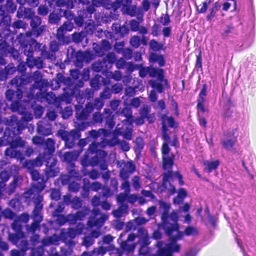

In [0]:
image = PIL.Image.open('zoom_1_256_256_partition_truncated/train/slide/' + df_train.zoom_1_file_name.iloc[0]
)
image

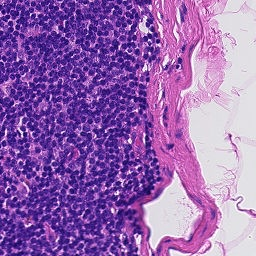

In [0]:

image = PIL.Image.open('zoom_2_256_256_zoom_1_pair_truncated/train/slide/' + df_train.zoom_2_file_name.iloc[0])
image

### Balance data through undersampling

In [0]:
# downsample df 
df_train['zoom_1_label'].value_counts()


0    51283
1     7344
Name: zoom_1_label, dtype: int64

In [0]:
df_down = pd.concat([df_train[df_train['zoom_1_label'] == '0'].sample(7344), df_train[df_train['zoom_1_label'] == '1']], axis = 0)
df_down = df_down.sample(frac=1).reset_index(drop=True)

In [0]:
df_down.head()

,zoom_1_file_name,img_id,zoom_1_include,zoom_1_label,zoom_1_non_gray_ratio,type,zoom_1_is_roi,zoom_2_file_name
0,tumor_slide_094_split_60_36.png,94,1,0,0.587021,train,1,tumor_slide_094_split_60_36_overlap_128_offset...
1,tumor_slide_035_split_156_62.png,35,1,0,0.702545,train,1,tumor_slide_035_split_156_62_overlap_128_offse...
2,tumor_slide_084_split_25_90.png,84,1,1,0.965469,train,1,tumor_slide_084_split_25_90_overlap_128_offset...
3,tumor_slide_084_split_30_72.png,84,1,0,0.964218,train,1,tumor_slide_084_split_30_72_overlap_128_offset...
4,tumor_slide_075_split_33_118.png,75,1,1,0.869370,train,1,tumor_slide_075_split_33_118_overlap_128_offse...


In [0]:
df_down.zoom_1_label.value_counts()

0    7344
1    7344
Name: zoom_1_label, dtype: int64

### Balance data through oversampling

In [0]:
df_up = pd.concat([df_train, df_train[df_train['zoom_1_label'] == '1'].sample(48000, replace=True)], axis = 0)

In [0]:
df_up.zoom_1_label.value_counts()

1    55344
0    51283
Name: zoom_1_label, dtype: int64

## Create data generators 

### Generator for training data

In [0]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# read data from the train directory
train_generator_1 = datagen.flow_from_dataframe(dataframe = df_down, 
                                              directory = 'zoom_1_256_256_partition_truncated/train/slide',
                                              x_col = 'zoom_1_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(256,256), 
                                              batch_size=32,
                                              drop_duplicates=False,
                                              shuffle = False)

# read data from the train directory
train_generator_2 = datagen.flow_from_dataframe(dataframe = df_down, 
                                              directory = 'zoom_2_256_256_zoom_1_pair_truncated/train/slide',
                                              x_col = 'zoom_2_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(256,256), 
                                              batch_size=32,
                                              drop_duplicates=False,
                                              shuffle = False)



Found 14688 images belonging to 2 classes.
Found 14688 images belonging to 2 classes.


In [0]:
len(train_generator_1)

459

### Generator for validation data

In [0]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# read data from the train directory
val_generator_1 = datagen.flow_from_dataframe(dataframe = df_val, 
                                              directory = 'zoom_1_256_256_partition_truncated/val/slide',
                                              x_col = 'zoom_1_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(256,256), 
                                              batch_size=32,
                                              drop_duplicates=False,
                                              shuffle = False)

# read data from the train directory
val_generator_2 = datagen.flow_from_dataframe(dataframe = df_val, 
                                              directory = 'zoom_2_256_256_zoom_1_pair_truncated/val/slide',
                                              x_col = 'zoom_2_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(256,256), 
                                              batch_size=32,
                                              drop_duplicates=False,
                                              shuffle = False)



Found 16239 images belonging to 2 classes.
Found 16239 images belonging to 2 classes.


In [0]:
len(val_generator_1)

508

### Generator for test data

In [0]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# read data from the train directory
test_generator_1 = datagen.flow_from_dataframe(dataframe = df_test, 
                                              directory = 'zoom_1_256_256_partition_test_only/test/slide',
                                              x_col = 'zoom_1_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(256,256), 
                                              batch_size=32,
                                              drop_duplicates=False,
                                              shuffle = False)

# read data from the train directory
test_generator_2 = datagen.flow_from_dataframe(dataframe = df_test, 
                                              directory = 'zoom_1_256_256_partition_test_only/test/slide',
                                              x_col = 'zoom_2_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(256,256), 
                                              batch_size=32,
                                              drop_duplicates=False,
                                              shuffle = False)



Found 19289 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


### Make sure the generators get matched patches from different zoom levels 

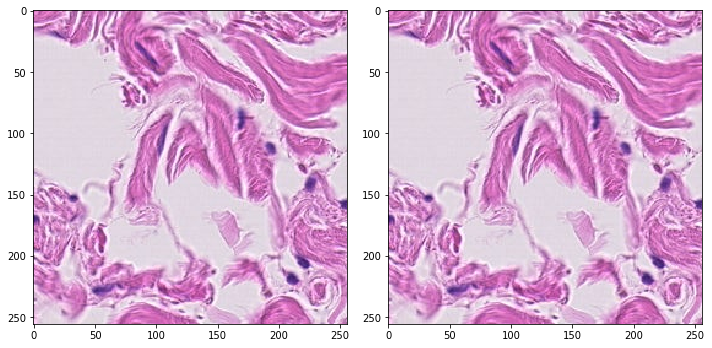

In [0]:
# plot images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 2, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator_1[0][0][0] for i in range(2)]

plotImages(augmented_images)

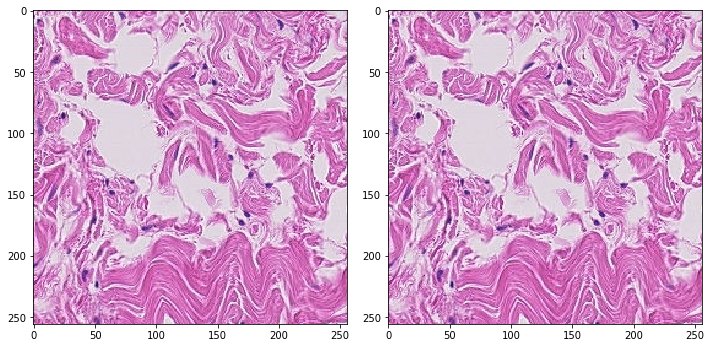

In [0]:
augmented_images = [train_generator_2[0][0][0] for i in range(2)]

plotImages(augmented_images)

# Build Models for Classification Task

In [0]:
# load more libraries
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, concatenate, Conv2D, Flatten, MaxPool2D, add
from tensorflow.keras.models import Model

import pydot
import graphviz
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc


## Naive baseline

In [0]:
df_val['zoom_1_label'].value_counts(normalize = True)

0    0.912495
1    0.087505
Name: zoom_1_label, dtype: float64

## Tiny CNN baseline

In [0]:
# specify simple model architecture
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

# print model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 252, 252, 32)      18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 250, 250, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32000064  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total para

In [0]:
EPOCHS = 20


if not os.path.exists(os.path.join(path, 'tiny_cnn')):
    os.mkdir(os.path.join(path, 'tiny_cnn'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'tiny_cnn',
    'tiny_cnn_{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

history_1 = model.fit_generator(train_generator_1,
                   epochs = EPOCHS,
                   validation_data = val_generator_1,
                   verbose=1, 
                   callbacks = [checkpoint])

Epoch 1/20
459/459 [==============================] - 213s 463ms/step - loss: 0.5987 - acc: 0.7788 - val_loss: 0.2775 - val_acc: 0.9111
Epoch 2/20
459/459 [==============================] - 188s 409ms/step - loss: 0.3182 - acc: 0.8625 - val_loss: 0.3756 - val_acc: 0.8728
Epoch 3/20
459/459 [==============================] - 184s 401ms/step - loss: 0.2577 - acc: 0.8970 - val_loss: 0.6103 - val_acc: 0.6874
Epoch 4/20
459/459 [==============================] - 186s 404ms/step - loss: 0.1788 - acc: 0.9335 - val_loss: 0.3800 - val_acc: 0.9015
Epoch 5/20
459/459 [==============================] - 186s 405ms/step - loss: 0.4194 - acc: 0.7898 - val_loss: 0.3251 - val_acc: 0.8681
Epoch 6/20
459/459 [==============================] - 189s 411ms/step - loss: 0.1604 - acc: 0.9381 - val_loss: 0.6142 - val_acc: 0.7861
Epoch 7/20
459/459 [==============================] - 185s 404ms/step - loss: 0.0488 - acc: 0.9850 - val_loss: 0.8323 - val_acc: 0.8053
Epoch 8/20
459/459 [============================

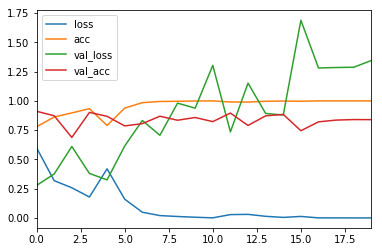

In [0]:
pd.DataFrame(history_1.history).plot()

## Small CNN

In [0]:
# try with balanced class weights
import sklearn
import numpy as np

y_train = df_train['label']
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train
print(class_weights)

# create class weights dictionary
cw = dict(zip([0,1], class_weights))
# doesnt work for some reason 
print(cw)

array([0.58759768, 3.35395683])

In [0]:
# specify model architecture
model_2 = tf.keras.Sequential()

model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(60, 60, 3)))
model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(tf.keras.layers.MaxPooling2D((2, 2)))

model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Flatten(input_shape = (60, 60, 3)))
model_2.add(tf.keras.layers.Dense(256, activation='relu'))
model_2.add(tf.keras.layers.Dense(128, activation='tanh'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# recompile model
model_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model_2.summary()

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'small_cnn')):
    os.mkdir(os.path.join(path, 'small_cnn'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'small_cnn',
    'small_cnn_{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)

history_2 = model_2.fit_generator(train_generator,
                   epochs = EPOCHS,
                   validation_data = val_generator,
                   # class_weight = class_weights,
                   shuffle=True,
                   callbacks = [checkpoint, stopping])

Epoch 1/40
256/256 [==============================] - 16s 61ms/step - loss: 0.6417 - acc: 0.6007 - val_loss: 0.4047 - val_acc: 0.8807
Epoch 2/40
256/256 [==============================] - 16s 62ms/step - loss: 0.4836 - acc: 0.7635 - val_loss: 0.3819 - val_acc: 0.8807
Epoch 3/40
256/256 [==============================] - 15s 59ms/step - loss: 0.4575 - acc: 0.7765 - val_loss: 0.4504 - val_acc: 0.8691
Epoch 4/40
256/256 [==============================] - 16s 63ms/step - loss: 0.4310 - acc: 0.7904 - val_loss: 0.3667 - val_acc: 0.8807
Epoch 5/40
256/256 [==============================] - 15s 60ms/step - loss: 0.4260 - acc: 0.7937 - val_loss: 0.3291 - val_acc: 0.8807
Epoch 6/40
256/256 [==============================] - 15s 59ms/step - loss: 0.4070 - acc: 0.8051 - val_loss: 0.3884 - val_acc: 0.8714
Epoch 7/40
256/256 [==============================] - 15s 59ms/step - loss: 0.4011 - acc: 0.8127 - val_loss: 0.3195 - val_acc: 0.8807
Epoch 8/40
256/256 [==============================] - 15s 59ms

In [0]:
model.predict(val_generator)

array([[0.2554441 ],
       [0.90633047],
       [0.2586465 ],
       ...,
       [0.09441949],
       [0.0263592 ],
       [0.3309168 ]], dtype=float32)

## Large CNN

In [0]:
model_3 = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), input_shape = (60,60,3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),   
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  
    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  
    
    tf.keras.layers.Flatten(), 
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.25),

    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model_3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'large_cnn')):
    os.mkdir(os.path.join(path, 'large_cnn'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'large_cnn',
    'large_cnn{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)

history_3 = model_3.fit_generator(train_generator,
                   epochs = EPOCHS,
                   validation_data = val_generator,
                   # class_weight = class_weights,
                   shuffle=True,
                   callbacks = [checkpoint, stopping])

Epoch 1/100
256/256 [==============================] - 8s 33ms/step - loss: 0.0269 - acc: 0.9938 - val_loss: 1.3814 - val_acc: 0.8737
Epoch 2/100
256/256 [==============================] - 8s 33ms/step - loss: 0.0123 - acc: 0.9969 - val_loss: 1.8202 - val_acc: 0.8784
Epoch 3/100
256/256 [==============================] - 9s 36ms/step - loss: 0.0174 - acc: 0.9963 - val_loss: 1.8930 - val_acc: 0.8589
Epoch 4/100
256/256 [==============================] - 9s 36ms/step - loss: 0.0467 - acc: 0.9941 - val_loss: 1.1924 - val_acc: 0.8457
Epoch 5/100
256/256 [==============================] - 9s 33ms/step - loss: 0.0162 - acc: 0.9958 - val_loss: 1.9406 - val_acc: 0.8659
Epoch 6/100
256/256 [==============================] - 8s 33ms/step - loss: 0.0057 - acc: 0.9977 - val_loss: 2.0328 - val_acc: 0.8683
Epoch 7/100
256/256 [==============================] - 8s 33ms/step - loss: 0.0245 - acc: 0.9952 - val_loss: 1.9774 - val_acc: 0.8644
Epoch 8/100
256/256 [==============================] - 9s 33ms

## Large CNN with batch normalization

In [0]:
model_4 = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), input_shape = (256,256,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),   
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(), 
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  
    
    tf.keras.layers.Flatten(), 
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate = 0.15),

    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model_4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [0]:
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_200 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 254, 254, 32)      128       
_________________________________________________________________
conv2d_201 (Conv2D)          (None, 252, 252, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 252, 252, 32)      0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 252, 252, 32)      128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 126, 126, 32)      0         
__________

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'large_cnn_bn')):
    os.mkdir(os.path.join(path, 'large_cnn_bn'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'large_cnn_bn',
    'large_cnn_bn{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)

history_4 = model_4.fit_generator(train_generator,
                   epochs = EPOCHS,
                   validation_data = val_generator,
                   # class_weight = class_weights,
                   shuffle=True,
                   callbacks = [checkpoint, stopping])

## Huge CNN with residual connections

In [0]:
inputs = Input(shape=(256, 256, 3))

x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
maxpool1 = MaxPool2D(pool_size=(2, 2))(x1)

x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool1)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)


x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)


x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x2)
skip2 = add([maxpool1, x2])
maxpool2 = MaxPool2D(pool_size=(2, 2))(skip2)

x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool2)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)

x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)

x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x3 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
skip3 = add([maxpool2, x3])
maxpool3 = MaxPool2D(pool_size=(2, 2))(skip3)

x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(maxpool3)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)

x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)

x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x4 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
skip4 = add([maxpool3, x4])
maxpool4 = MaxPool2D(pool_size=(2, 2))(skip4)

flat = Flatten()(maxpool4)
dense = Dense(128, activation='relu')(flat)
dense = Dense(64, activation='relu')(dense)
predictions = Dense(1, activation='sigmoid')(dense)

model_5 = Model(inputs=inputs, outputs=predictions)

model_5.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
model_5.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 256, 256, 32) 896         input_32[0][0]                   
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_150[0][0]                 
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_151[0][0]                 
__________________________________________________________________________________________________
conv2d_153

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'large_cnn_res')):
    os.mkdir(os.path.join(path, 'large_cnn_res'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'large_cnn_res',
    'large_cnn_res{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)

history_5 = model_5.fit_generator(train_generator_1,
                   epochs = EPOCHS,
                   validation_data = val_generator_1,
                   # class_weight = class_weights,
                   shuffle=True,
                   callbacks = [checkpoint, stopping])

Epoch 1/20
459/459 [==============================] - 385s 839ms/step - loss: 0.3945 - acc: 0.8187 - val_loss: 0.2396 - val_acc: 0.9136
Epoch 2/20
459/459 [==============================] - 362s 788ms/step - loss: 0.2602 - acc: 0.8904 - val_loss: 0.2827 - val_acc: 0.8956
Epoch 3/20
459/459 [==============================] - 361s 787ms/step - loss: 0.2383 - acc: 0.8989 - val_loss: 0.6879 - val_acc: 0.7584
Epoch 4/20
459/459 [==============================] - 364s 794ms/step - loss: 0.2196 - acc: 0.9105 - val_loss: 0.4474 - val_acc: 0.8606


## Transfer learning with VGG16

In [0]:
from tensorflow.keras.applications import VGG16, VGG19

In [0]:
conv_base_1 = VGG16(weights='imagenet',
                    include_top=False, 
                    input_shape=(256, 256, 3))


58892288/58889256 [==============================] - 2s 0us/step


In [0]:
conv_base_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
# instantiate model
model_6 = tf.keras.models.Sequential()

model_6.add(conv_base_1)
model_6.add(tf.keras.layers.Flatten())
model_6.add(tf.keras.layers.Dense(256, activation='relu'))
model_6.add(tf.keras.layers.Dropout(rate = 0.4))
model_6.add(tf.keras.layers.Dense(256, activation='relu'))
model_6.add(tf.keras.layers.Dropout(rate = 0.4))
model_6.add(tf.keras.layers.Dense(128, activation='relu'))
model_6.add(tf.keras.layers.Dropout(rate = 0.4))
model_6.add(tf.keras.layers.Dense(1, activation='sigmoid'))

conv_base_1.trainable = False

model_6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
__________

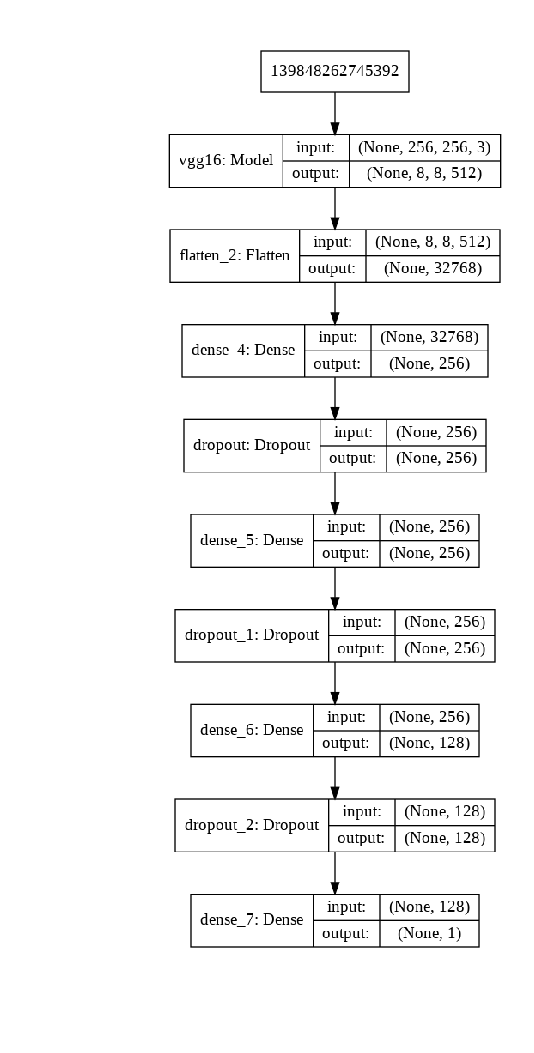

In [0]:
image_path = 'model.png'
keras.utils.plot_model(model_6, 
                       show_shapes=True,
                       to_file=image_path)

plt.figure(dpi=300)
imgplot = plt.imshow(mpimg.imread(image_path))
plt.axis('off')
plt.show()

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'VGG16')):
    os.mkdir(os.path.join(path, 'VGG16'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'VGG16',
    'VGG16{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)

history_6 = model_6.fit_generator(train_generator_1,
                   epochs = EPOCHS,
                   validation_data = val_generator_1,
                   # class_weight = class_weights,
                   shuffle=True,
                   callbacks = [checkpoint, stopping])

Epoch 1/20
459/459 [==============================] - 203s 443ms/step - loss: 0.3773 - acc: 0.8436 - val_loss: 0.2223 - val_acc: 0.9374
Epoch 2/20
459/459 [==============================] - 200s 436ms/step - loss: 0.2907 - acc: 0.8700 - val_loss: 0.2825 - val_acc: 0.9551
Epoch 3/20
459/459 [==============================] - 201s 438ms/step - loss: 0.2665 - acc: 0.8853 - val_loss: 0.1934 - val_acc: 0.9464
Epoch 4/20
459/459 [==============================] - 200s 437ms/step - loss: 0.2431 - acc: 0.8962 - val_loss: 0.1977 - val_acc: 0.9480
Epoch 5/20
459/459 [==============================] - 201s 438ms/step - loss: 0.2342 - acc: 0.8994 - val_loss: 0.1702 - val_acc: 0.9414
Epoch 6/20
459/459 [==============================] - 200s 436ms/step - loss: 0.2266 - acc: 0.8975 - val_loss: 0.1996 - val_acc: 0.9411
Epoch 7/20
459/459 [==============================] - 201s 438ms/step - loss: 0.2247 - acc: 0.9038 - val_loss: 0.1653 - val_acc: 0.9507
Epoch 8/20
459/459 [============================

Text(0.5, 1.0, 'Learning Curve')

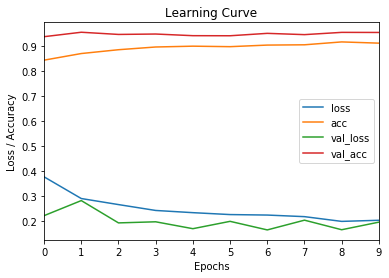

In [0]:
pd.DataFrame(history_6.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Learning Curve')

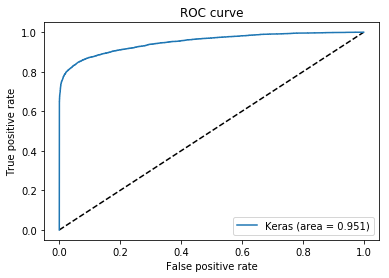

In [0]:
y_pred = model_6.predict_generator(test_generator_1).ravel()
y_test = test_generator_1.classes
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_keras = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Double Input CNNs

### Need to create a custom image generator

In [0]:
# specify image data generator with augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

def generate_generator_multiple(generator, df1, dir1, df2, dir2, batch_size, img_height, img_width):
  
    genX1 = generator.flow_from_dataframe(dataframe = df1, 
                                              directory = dir1,
                                              x_col = 'zoom_1_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(img_height, img_width), 
                                              batch_size = batch_size,
                                              drop_duplicates=False,
                                              shuffle = False)
    
    genX2 = generator.flow_from_dataframe(dataframe = df2, 
                                              directory = dir2,
                                              x_col = 'zoom_2_file_name', 
                                              y_col='zoom_1_label',
                                              class_mode='binary', 
                                              target_size=(img_height, img_width), 
                                              batch_size=batch_size,
                                              drop_duplicates=False,
                                              shuffle = False)

    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            
            
train_generator = generate_generator_multiple(generator = datagen,
                                              df1 = df_down,
                                              dir1 = 'zoom_1_256_256_partition_truncated/train/slide',
                                              df2 = df_down,
                                              dir2= 'zoom_2_256_256_zoom_1_pair_truncated/train/slide',
                                              batch_size=32,
                                              img_height=256,
                                              img_width=256)       
     
val_generator = generate_generator_multiple(generator = datagen,
                                              df1 = df_val,
                                              dir1 = 'zoom_1_256_256_partition_truncated/val/slide',
                                              df2 = df_val,
                                              dir2= 'zoom_2_256_256_zoom_1_pair_truncated/val/slide',
                                              batch_size=32,
                                              img_height=256,
                                              img_width=256)           

test_generator = generate_generator_multiple(generator = datagen,
                                              df1 = df_test,
                                              dir1 = 'zoom_1_256_256_partition_test_only/test/slide',
                                              df2 = df_test,
                                              dir2= 'zoom_2_256_256_zoom_1_pair_val_test_roi/test/slide',
                                              batch_size=32,
                                              img_height=256,
                                              img_width=256)   



## Double input small CNN

In [0]:
# define two sets of inputs
zoom_1 = Input(shape=(256,256,3))
zoom_2 = Input(shape=(256,256,3))
 
# process zoom level 1 patch
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(zoom_1)
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_1)
conv_1 = Model(inputs=zoom_1, outputs=conv_1)
 
# process zoom level 2 patch
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(zoom_2)
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_2)
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_2)
conv_2 = Model(inputs=zoom_2, outputs=conv_2)
 
# combine output of convolutional layers
combined = concatenate([conv_1.output, conv_2.output])
flattened = Flatten()(combined)
 
# fully connected layer after combined outputs
z = Dense(2, activation="relu")(flattened)
z = Dense(2, activation="softmax")(z)
 
# instantiate model
model_7 = Model(inputs=[conv_1.input, conv_2.input], outputs=z)

model_7.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [0]:
model_7.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 32) 896         input_27[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 896         input_26[0][0]                   
__________________________________________________________________________________________________
conv2d_23 

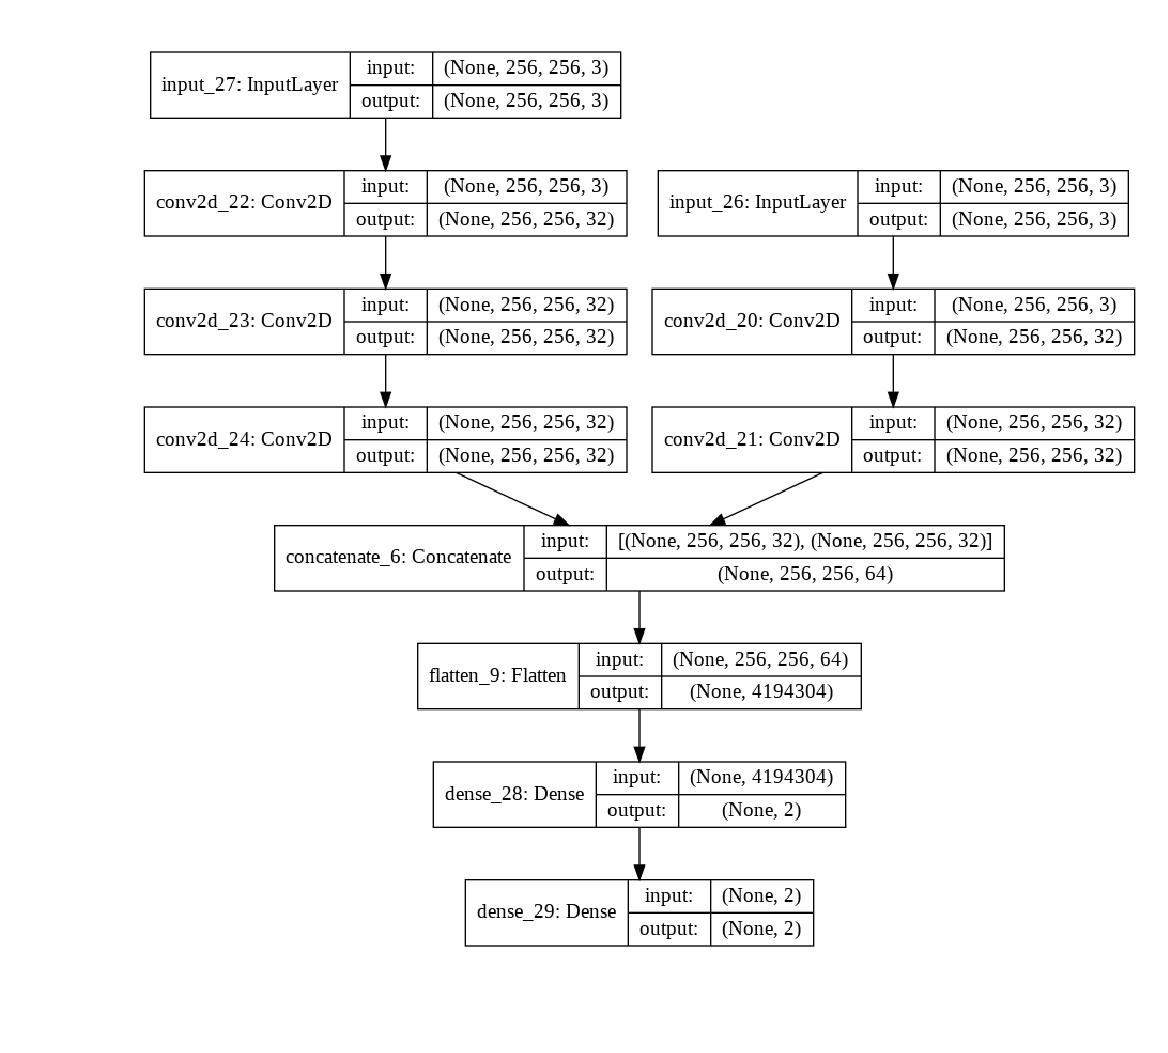

In [0]:
image_path = 'model.png'
keras.utils.plot_model(model_7, 
                       show_shapes=True,
                       to_file=image_path)

plt.figure(dpi=300)
imgplot = plt.imshow(mpimg.imread(image_path))
plt.axis('off')
plt.show()

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'double_input_custom')):
    os.mkdir(os.path.join(path, 'double_input_custom'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'double_input_custom',
    'double_input_custom{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)


history_7 = model_7.fit_generator(train_generator, validation_data=val_generator, 
                                  epochs = 100, steps_per_epoch = int(df_down.shape[0]/32), 
                                  validation_steps= int(df_val.shape[0]/32), shuffle = False, 
                                 callbacks = [checkpoint, stopping])

Found 14688 images belonging to 2 classes.
Found 14688 images belonging to 2 classes.
Epoch 1/100
458/459 [============================>.] - ETA: 0s - loss: 8.0430 - acc: 0.5002Found 16239 images belonging to 2 classes.
Found 16239 images belonging to 2 classes.
459/459 [==============================] - 440s 959ms/step - loss: 8.0606 - acc: 0.4991 - val_loss: 1.4117 - val_acc: 0.9124
Epoch 2/100
459/459 [==============================] - 442s 964ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 1.4117 - val_acc: 0.9124
Epoch 3/100
459/459 [==============================] - 434s 946ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 1.4117 - val_acc: 0.9124
Epoch 4/100
459/459 [==============================] - 439s 957ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 1.4117 - val_acc: 0.9124
Epoch 5/100
459/459 [==============================] - 433s 942ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 1.4117 - val_acc: 0.9124
Epoch 6/100
459/459 [==============================] - 434s 945m

## Double input large CNN

In [0]:
# define two sets of inputs
zoom_1 = Input(shape=(256,256,3))
zoom_2 = Input(shape=(256,256,3))
 
# process zoom level 1 patch
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(zoom_1)
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_1)
conv_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_1)
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_1)
conv_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_1)
conv_1 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_1)
conv_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
conv_1 = Model(inputs=zoom_1, outputs=conv_1)
 
# process zoom level 2 patch
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(zoom_2)
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_2)
conv_2 = MaxPool2D(pool_size=(2, 2))(conv_2)
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_2)
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_2)
conv_2 = MaxPool2D(pool_size=(2, 2))(conv_2)
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_2)
conv_2 = Conv2D(32, (3,3), padding = 'same', activation="relu")(conv_2)
conv_2 = MaxPool2D(pool_size=(2, 2))(conv_2)
conv_2 = Model(inputs=zoom_2, outputs=conv_2)
 
# combine output of convolutional layers
combined = concatenate([conv_1.output, conv_2.output])
flattened = Flatten()(combined)
 
# fully connected layers after combined outputs
z = Dense(128, activation="relu")(flattened)
z = Dense(64, activation="relu")(z)
z = Dense(2, activation="softmax")(z)
 
# instantiate model
model_8 = Model(inputs=[conv_1.input, conv_2.input], outputs=z)
model_8.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

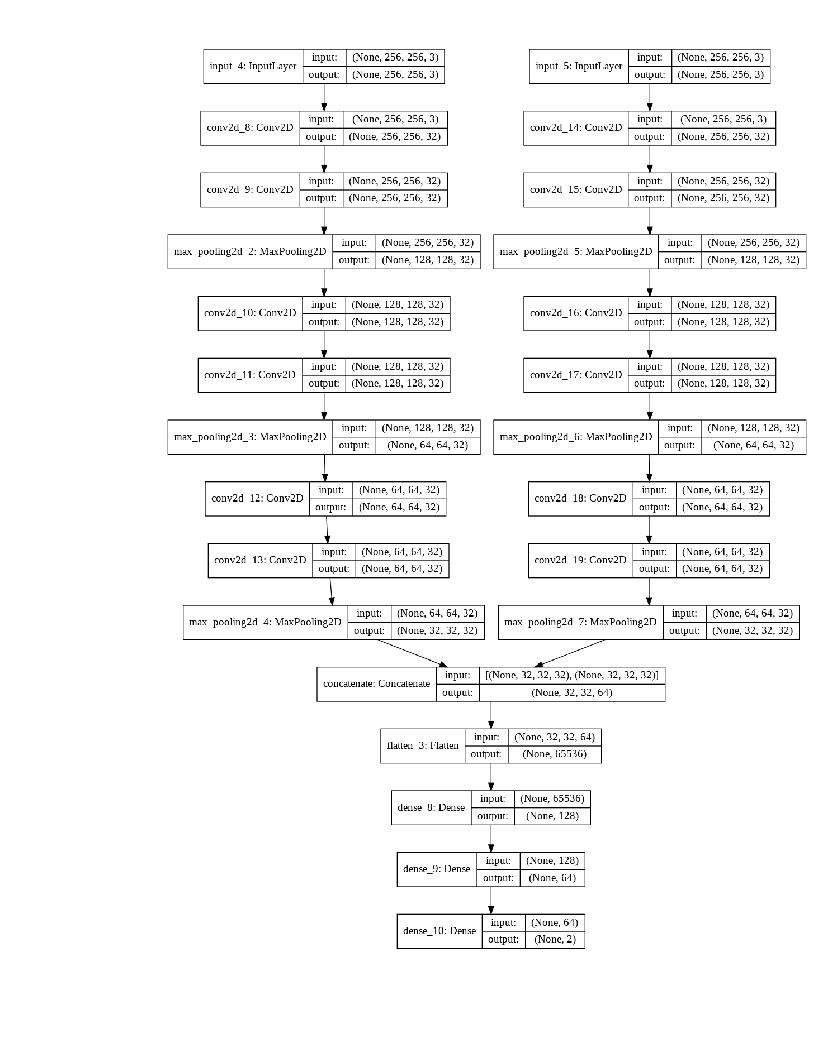

In [0]:
image_path = 'model.png'
keras.utils.plot_model(model_8, 
                       show_shapes=True,
                       to_file=image_path)

plt.figure(dpi=300)
imgplot = plt.imshow(mpimg.imread(image_path))
plt.axis('off')
plt.show()

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'double_input_large')):
    os.mkdir(os.path.join(path, 'double_input_large'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'double_input_large',
    'double_input_large{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)


history_8 = model_8.fit_generator(train_generator, validation_data=val_generator, 
                                  epochs = 100, steps_per_epoch = int(df_down.shape[0]/32), 
                                  validation_steps= int(df_val.shape[0]/32), shuffle = False, 
                                 callbacks = [checkpoint, stopping])

Found 14688 images belonging to 2 classes.
Found 14688 images belonging to 2 classes.
Epoch 1/100
458/459 [============================>.] - ETA: 0s - loss: 0.4136 - acc: 0.8096Found 16239 images belonging to 2 classes.
Found 16239 images belonging to 2 classes.
459/459 [==============================] - 457s 997ms/step - loss: 0.4135 - acc: 0.8097 - val_loss: 0.2524 - val_acc: 0.9122
Epoch 2/100
459/459 [==============================] - 456s 993ms/step - loss: 0.3041 - acc: 0.8702 - val_loss: 0.2747 - val_acc: 0.9137
Epoch 3/100
459/459 [==============================] - 453s 987ms/step - loss: 0.2538 - acc: 0.8945 - val_loss: 0.2435 - val_acc: 0.9116
Epoch 4/100
459/459 [==============================] - 456s 994ms/step - loss: 0.1855 - acc: 0.9274 - val_loss: 0.3341 - val_acc: 0.9005
Epoch 5/100
459/459 [==============================] - 459s 999ms/step - loss: 0.1414 - acc: 0.9476 - val_loss: 0.5790 - val_acc: 0.7991
Epoch 6/100
459/459 [==============================] - 458s 999m

KeyboardInterrupt: ignored

## Double input transfer learning with VGG16 and VGG19

In [0]:
from tensorflow.keras.layers import Input, concatenate, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.models import Model

In [0]:
# define convolutional base for each stream
conv_base_zoom_1 = VGG19(weights='imagenet',
                    include_top=False, 
                    input_shape=(256, 256, 3))

conv_base_zoom_2 = VGG16(weights='imagenet',
                    include_top=False, 
                    input_shape=(256, 256, 3))

conv_base_zoom_1.trainable = False
conv_base_zoom_2.trainable = False

# define two sets of inputs
zoom_1 = Input(shape=(256,256,3))
zoom_2 = Input(shape=(256,256,3))
 
# process zoom level 1 patch
conv_1 = conv_base_zoom_1(zoom_1)
conv_1 = Model(inputs=zoom_1, outputs=conv_1)
 
# process zoom level 2 patch
conv_2 = conv_base_zoom_2(zoom_2)
conv_2 = Model(inputs=zoom_2, outputs=conv_2)
 
# combine output of convolutional layers
combined = concatenate([conv_1.output, conv_2.output])
flattened = Flatten()(combined)
 
# fully connected layers after combined outputs
z = Dense(512, activation="relu")(flattened)
z = Dropout(rate = 0.4)(z)
z = Dense(256, activation="relu")(z)
z = Dropout(rate = 0.4)(z)
z = Dense(128, activation="relu")(z)
z = Dropout(rate = 0.4)(z)
#z = Dense(1, activation='sigmoid')(z)
z = Dense(2, activation="softmax")(z)
 
# instantiate model
model_9 = Model(inputs=[conv_1.input, conv_2.input], outputs=z)
model_9.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [0]:
model_9.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
vgg19 (Model)                   (None, 8, 8, 512)    20024384    input_24[0][0]                   
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 8, 8, 512)    14714688    input_25[0][0]                   
__________________________________________________________________________________________________
concatenat

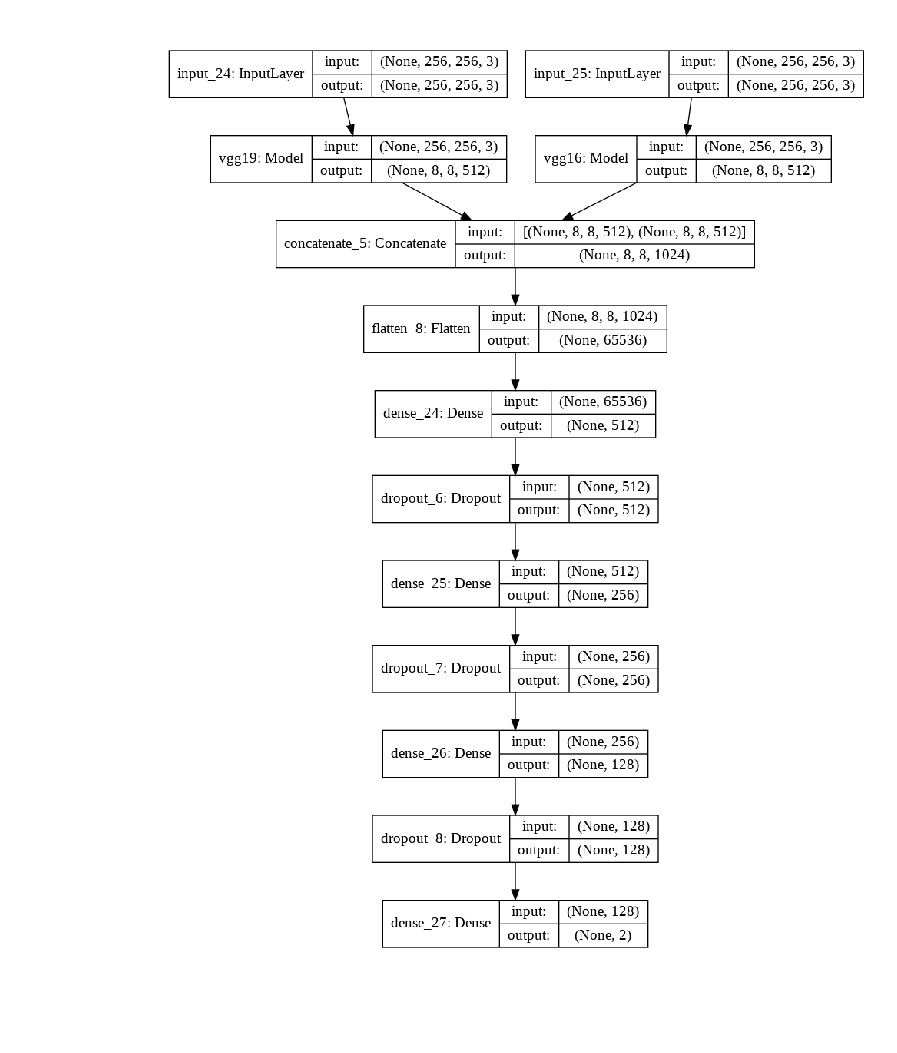

In [0]:
image_path = 'model.png'
keras.utils.plot_model(model_9, 
                       show_shapes=True,
                       to_file=image_path)

plt.figure(dpi=300)
imgplot = plt.imshow(mpimg.imread(image_path))
plt.axis('off')
plt.show()

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'double_input_transfer')):
    os.mkdir(os.path.join(path, 'double_input_transfer'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'double_input_transfer',
    'double_input_transfer{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)


history_9 = model_9.fit_generator(train_generator, validation_data=val_generator, 
                                  epochs = EPOCHS, steps_per_epoch = int(df_down.shape[0]/32), 
                                  validation_steps= int(df_val.shape[0]/32), shuffle = False, 
                                 callbacks = [checkpoint, stopping])

Epoch 1/100
459/459 [==============================] - 518s 1s/step - loss: 3.1550 - acc: 0.7894 - val_loss: 1.3954 - val_acc: 0.9086
Epoch 2/100
459/459 [==============================] - 512s 1s/step - loss: 2.5188 - acc: 0.8403 - val_loss: 1.0229 - val_acc: 0.9352
Epoch 3/100
459/459 [==============================] - 518s 1s/step - loss: 2.2396 - acc: 0.8589 - val_loss: 1.0579 - val_acc: 0.9337
Epoch 4/100
459/459 [==============================] - 537s 1s/step - loss: 2.0193 - acc: 0.8734 - val_loss: 0.8161 - val_acc: 0.9488
Epoch 5/100
459/459 [==============================] - 542s 1s/step - loss: 2.2109 - acc: 0.8621 - val_loss: 1.9137 - val_acc: 0.8806
Epoch 6/100
459/459 [==============================] - 527s 1s/step - loss: 3.0316 - acc: 0.8111 - val_loss: 0.9910 - val_acc: 0.9382
Epoch 7/100
459/459 [==============================] - 524s 1s/step - loss: 3.8930 - acc: 0.7580 - val_loss: 0.8491 - val_acc: 0.9472


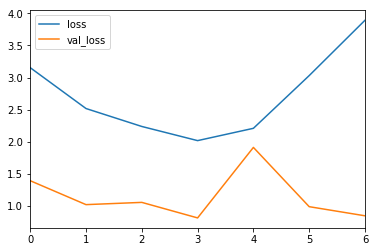

In [0]:
pd.DataFrame(history_9.history)[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

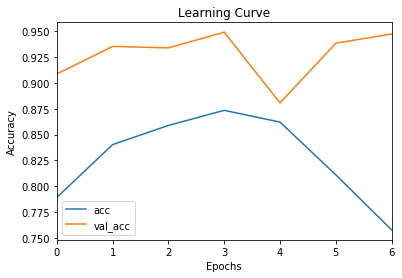

In [0]:
pd.DataFrame(history_9.history)[['acc', 'val_acc']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

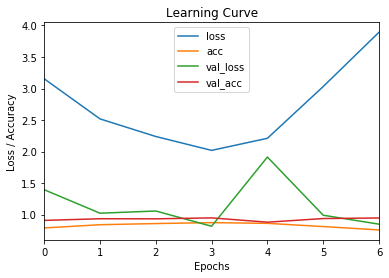

In [0]:
pd.DataFrame(history_9.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Learning Curve')

In [0]:
y_pred = model_9.predict_generator(test_generator, steps = int(df_test.shape[0]/32)).ravel()
y_test = df_test.zoom_1_label
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_keras = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: ignored

In [0]:
EPOCHS = 20

if not os.path.exists(os.path.join(path, 'double_input_transfer')):
    os.mkdir(os.path.join(path, 'double_input_transfer'))

checkpoint = ModelCheckpoint(filepath = os.path.join(path, 'double_input_transfer',
    'double_input_transfer{epoch:02d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.h5'),
    save_weights_only=True)

stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, 
                         verbose=0, mode='auto', baseline=None, 
                         restore_best_weights=True)


history_9 = model_9.fit_generator(train_generator, validation_data=val_generator, 
                                  epochs = EPOCHS, steps_per_epoch = int(df_down.shape[0]/32), 
                                  validation_steps= int(df_val.shape[0]/32), shuffle = False, 
                                 callbacks = [checkpoint, stopping])

Epoch 1/20
Found 14688 images belonging to 2 classes.
Found 14688 images belonging to 2 classes.
458/459 [============================>.] - ETA: 0s - loss: 2.2197 - acc: 0.8613Found 16239 images belonging to 2 classes.
Found 16239 images belonging to 2 classes.
459/459 [==============================] - 531s 1s/step - loss: 2.2204 - acc: 0.8612 - val_loss: 1.2083 - val_acc: 0.9244
Epoch 2/20
459/459 [==============================] - 525s 1s/step - loss: 2.2550 - acc: 0.8593 - val_loss: 0.8353 - val_acc: 0.9479
Epoch 3/20
459/459 [==============================] - 528s 1s/step - loss: 2.5678 - acc: 0.8403 - val_loss: 0.7508 - val_acc: 0.9531
Epoch 4/20
459/459 [==============================] - 521s 1s/step - loss: 2.6598 - acc: 0.8344 - val_loss: 0.7598 - val_acc: 0.9527
Epoch 5/20
459/459 [==============================] - 522s 1s/step - loss: 5.1453 - acc: 0.6801 - val_loss: 1.4130 - val_acc: 0.9124
Epoch 6/20
459/459 [==============================] - 521s 1s/step - loss: 5.3663 - 

Text(0.5, 1.0, 'Learning Curve')

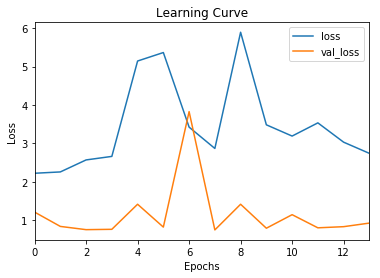

In [0]:
pd.DataFrame(history_9.history)[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

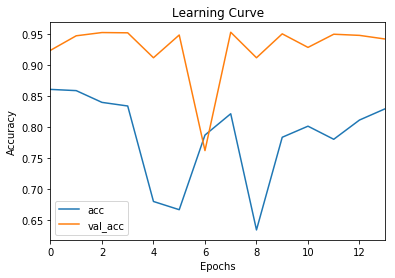

In [0]:
pd.DataFrame(history_9.history)[['acc', 'val_acc']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')

Text(0.5, 1.0, 'Learning Curve')

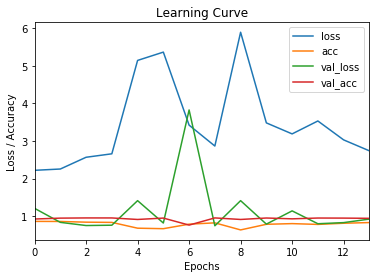

In [0]:
pd.DataFrame(history_9.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Learning Curve')